In [1]:

import torch
import logging
import statistics
import src.clip as clip
from torchinfo import summary
import torchvision.transforms as T
from accelerate import Accelerator
from yacs.config import CfgNode as CN
from main import get_config, init_accelerator, set_seed, FFPP
from src.models import Detector
logging.basicConfig(level="DEBUG")


class Obj:
    pass


c = FFPP.get_default_config()
# c.augmentation = "normal+frame"
# c.augmentation = "none"
c.pair = 1
c.compressions = ["c23"]
c.types = ["REAL", "NT"]


mc = Detector.get_default_config()
mc.out_dim = [2]
mc.adapter = CN()
mc.adapter.frozen = 0
mc.adapter.struct = CN()
# mc.adapter.struct.type = "legacy-768-x-768"
mc.adapter.struct.type = "768-x-768-nln"
mc.adapter.struct.x = 256
mc.adapter.type = "normal"

accelerator = Accelerator(mixed_precision='no')
model = Detector(mc, 20, accelerator).to(accelerator.device).eval()
# encoder = clip.load("ViT-B/16")[0].visual.float()
encoder = model.encoder
# adapter = model.adapter
# adapter.load_state_dict(
#     {
#         k[8:]: v for k, v in
#         torch.load(
#             # "/home/od/Desktop/repos/dfd-clip/logs/comp-inv/comp-inv/mode1+256+resi+1e-2/last_weights.pt",
#             "/home/od/Desktop/repos/dfd-clip/logs/test/0520T1305/best_weights.pt",
#             map_location="cpu"
#         ).items()
#         if "adapter" in k
#     }
# )
model.eval()
model.to("cuda")

transform = T.Compose([
    T.Resize(encoder.input_resolution, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(encoder.input_resolution),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711)),
])

x = FFPP(c.clone(), 20, 5, transform, accelerator, split="train")
_x = FFPP(c.clone(), 20, 5, lambda x: x, accelerator, split="train")
c

/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:Adapter operates without pretrained weights!!!
100%|██████████| 2/2 [00:00<00:00, 2539.69it/s]


CfgNode({'category': 'train', 'root_dir': './datasets/ffpp/', 'detection_level': 'video', 'types': ['REAL', 'NT'], 'compressions': ['c23'], 'name': 'FFPP', 'scale': 1.0, 'pack': 0, 'pair': 1, 'contrast': 0, 'augmentation': 'none', 'random_speed': 1})

In [2]:
import random
idx = random.randint(0, len(x))
data = x[idx]
_data = _x[idx]

DEBUG:root:Item/Video Index:1788/543
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 0.5902566884627345
DEBUG:root:Video Shift Factor: 0.32360133625594545
DEBUG:root:Loading Video: ./datasets/ffpp/real/raw/videos/699.avi
DEBUG:root:Sample Offset: 1
DEBUG:root:Sample Stride: 0.15157894736842104
DEBUG:root:Video: ./datasets/ffpp/real/raw/videos/699.avi, Completed!
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/699.avi
DEBUG:root:Sample Offset: 1
DEBUG:root:Sample Stride: 0.15157894736842104
DEBUG:root:Video: ./datasets/ffpp/real/c23/videos/699.avi, Completed!
DEBUG:root:Item/Video Index:1788/543
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 0.8771154148805776
DEBUG:root:Video Shift Factor: 0.08511906588752963
DEBUG:root:Loading Video: ./datasets/ffpp/real/raw/videos/699.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0.22736842105263158
DEBUG:root:Video: ./datasets/ffpp/real/raw/videos/699.avi, Completed!
DEBUG:root:Loa

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/od/anaconda3/envs/dfd-clip/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/od/anaconda3/envs/dfd-clip/lib/python3.8/s

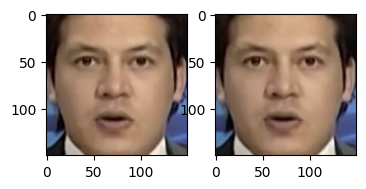

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(_data[0]["raw"][0].numpy().transpose((1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(_data[0]["c23"][0].numpy().transpose((1, 2, 0)))

In [4]:
# features = {}
# nfeatures = {}
# with torch.no_grad():
#     for k, v in data[0].items():
#         # get key and value from each CLIP ViT layer
#         kvs = encoder(v[0].unsqueeze(0).to("cuda"))
#         # discard original CLS token and restore temporal dimension
#         kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]

#         _kvs = [{k: v.unsqueeze(0) for k, v in kv.items()} for kv in kvs]
#         _kvs = adapter([kvs[i] for i in range(0, 12, 2)])

#         kvs = [{k: v.squeeze(0).view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in kvs]
#         features[k] = kvs
#         _kvs = [{k: v.squeeze(0).view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in _kvs]
#         nfeatures[k] = _kvs


# torch.cuda.empty_cache()

In [5]:
features = {}
# nfeatures = {}
with torch.no_grad():
    for k, v in data[0].items():
        # get key and value from each CLIP ViT layer
        kvs = encoder(v.to("cuda"), with_out=True)
        # discard original CLS token and restore temporal dimension
        kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]

        # _kvs = [{k: v.unsqueeze(0) for k, v in kv.items()} for kv in kvs]
        # _kvs = adapter([_kvs[i] for i in [5, 6, 7, 8, 9, 10]])
        kvs = [{k: v[0].view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in kvs]
        features[k] = kvs
        # _kvs = [{k: v[:, 0].view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in _kvs]
        # nfeatures[k] = _kvs


torch.cuda.empty_cache()

In [6]:
methods = []

In [7]:
ls = []
for l1 in range(12):
    l = {
        "k": [],
        "v": [],
        "out": []
    }
    for l2 in range(12):
        for subject in ["k", "v", "out"]:
            l[subject].append(
                torch.abs(features["raw"][l1][subject] - features["c23"][l2][subject]).mean(dim=-1).view(14, 14).numpy()
                # torch.nn.functional.mse_loss(
                #     features["raw"][l1][subject],
                #     features["c23"][l2][subject],
                #     reduction="none"
                # ).mean(dim=-1).view(14, 14).numpy()
            )
    ls.append(l)
methods.append(ls)

In [8]:
# torch.abs(features["raw"][5]["out"] - features["c23"][4]["out"]).mean(dim=-1).view(14, 14).numpy()

In [9]:
# ls = []
# for l1 in range(12):
#     l = {
#         "k": [],
#         "v": [],
#         "out": []
#     }
#     for l2 in range(12):
#         for subject in ["k", "v", "out"]:
#             l[subject].append(
#                 torch.nn.functional.kl_div(
#                     torch.nn.functional.log_softmax(features["raw"][l1][subject], dim=-1),
#                     torch.nn.functional.log_softmax(features["c23"][l2][subject], dim=-1),
#                     log_target=True,
#                     reduction="none"
#                 ).mean(dim=-1).view(14, 14).numpy()
#             )
#     ls.append(l)
# methods.append(ls)

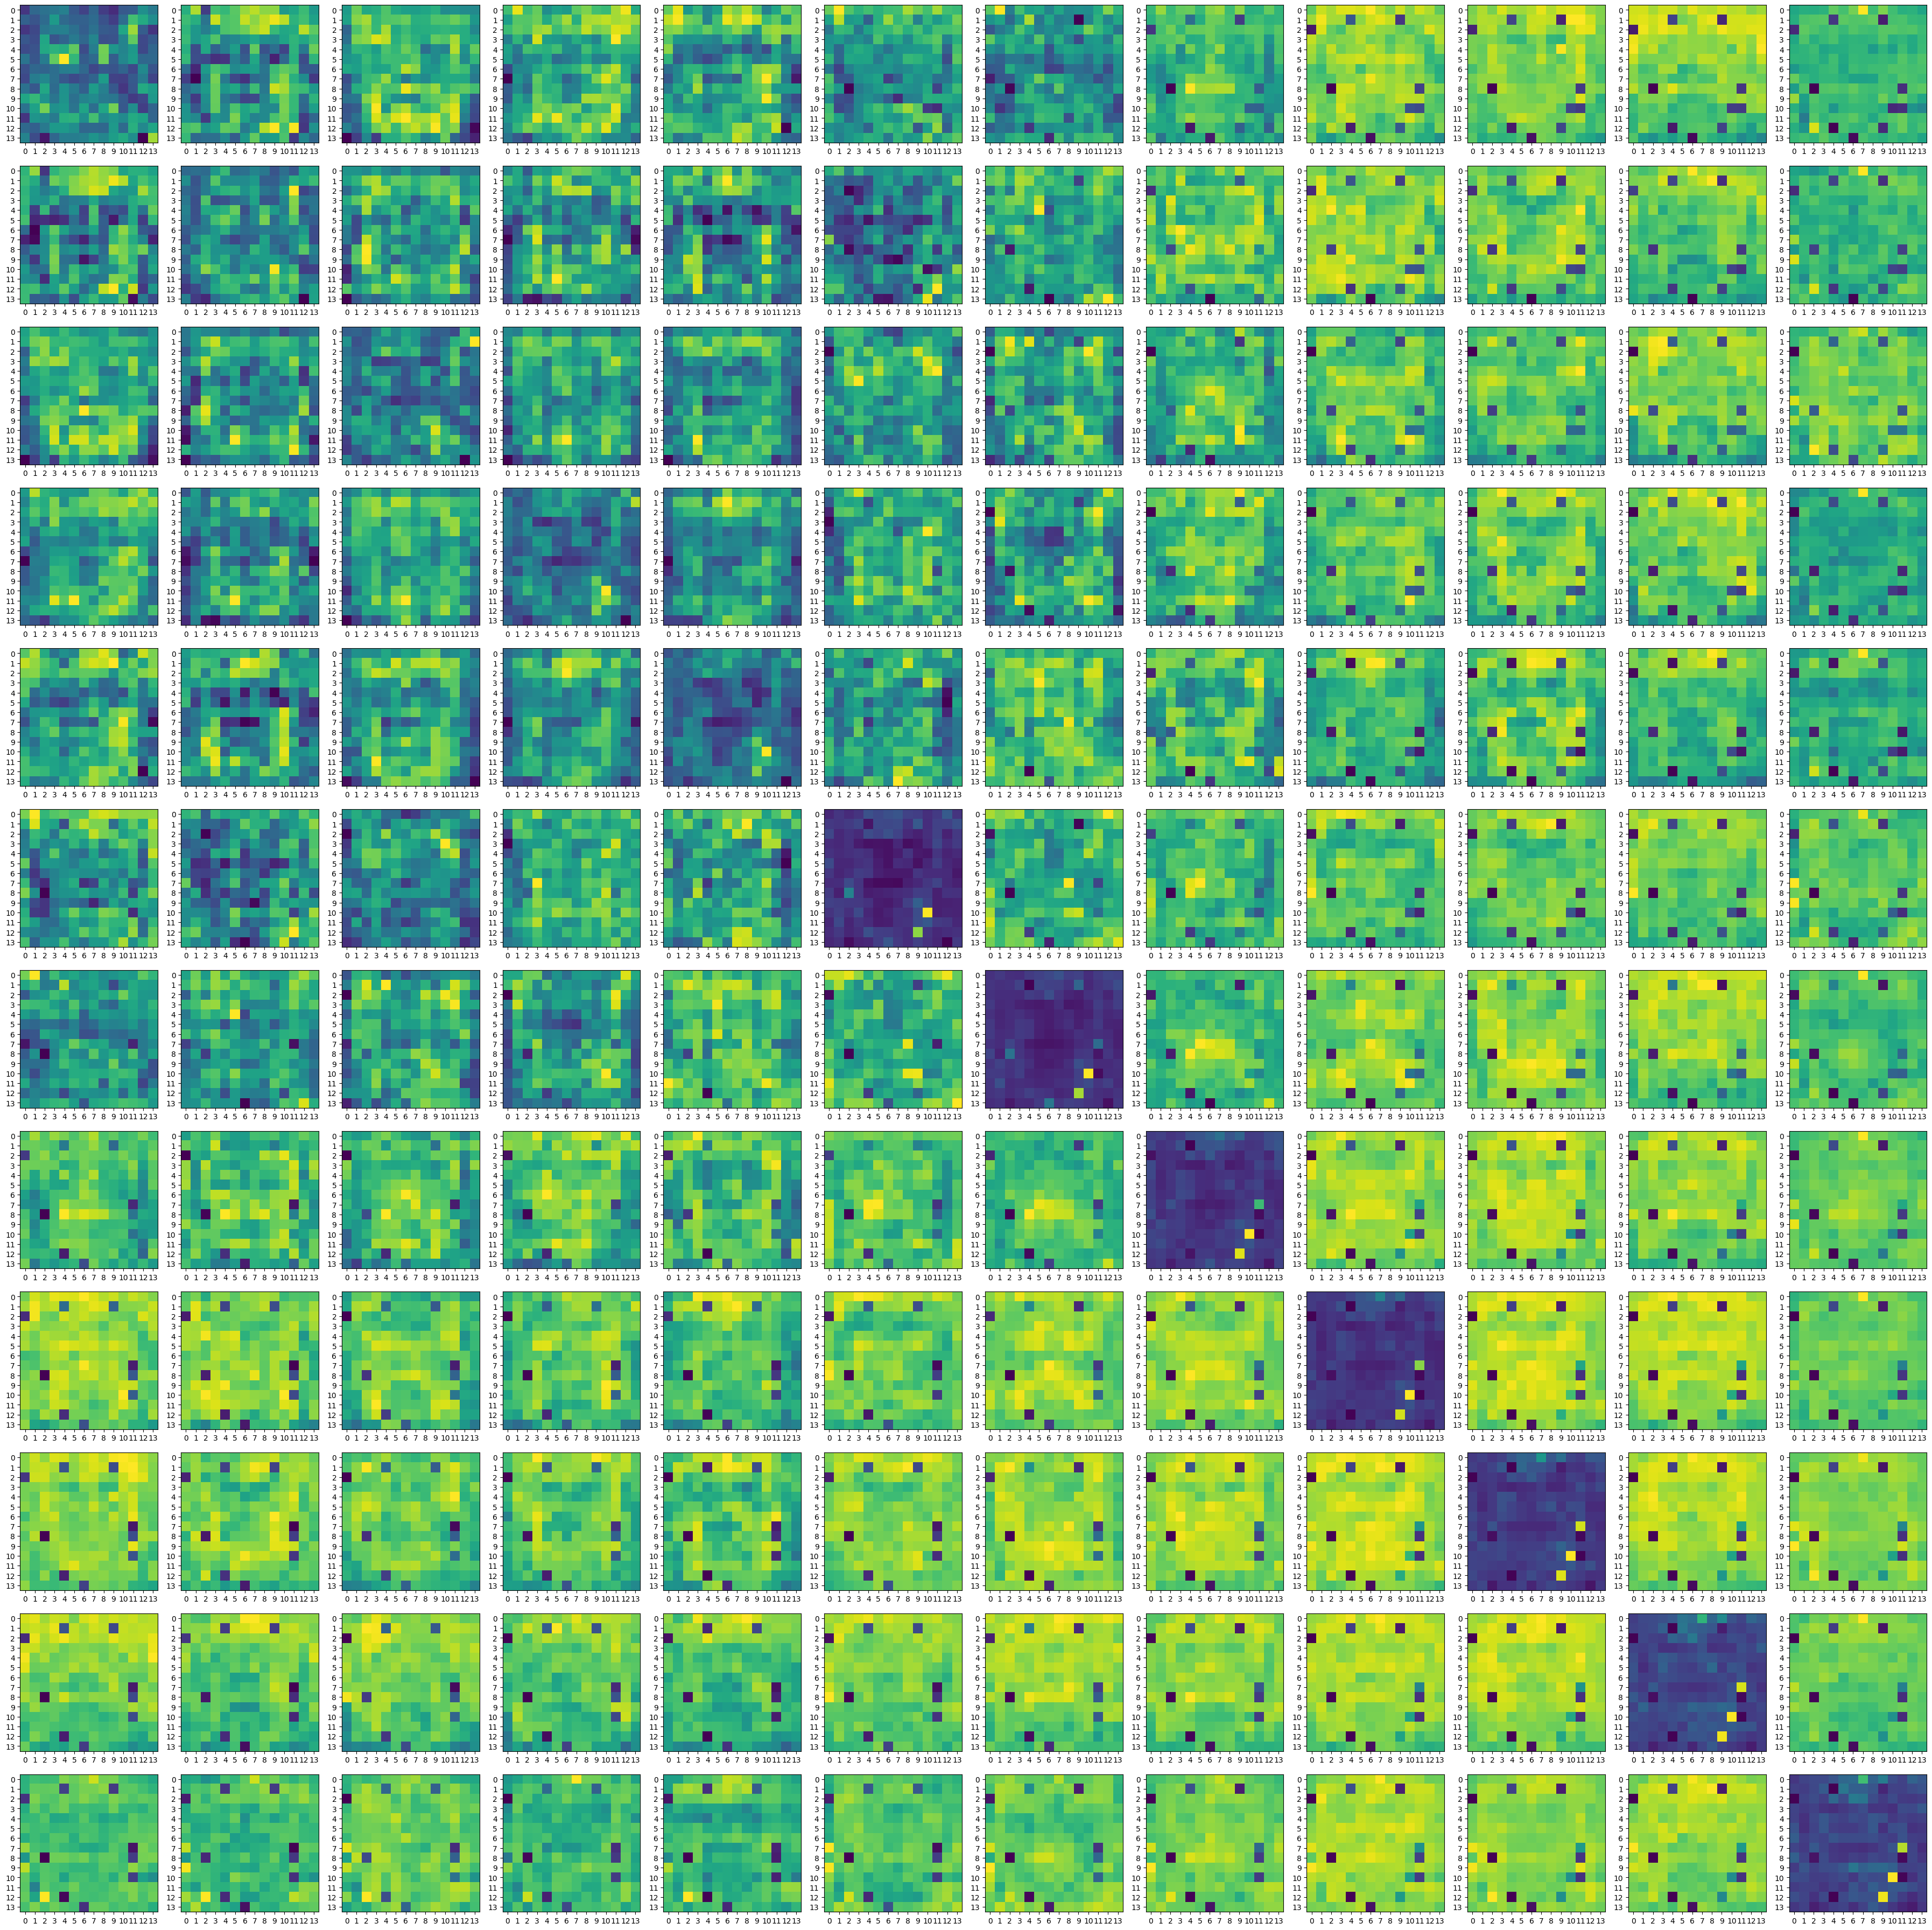

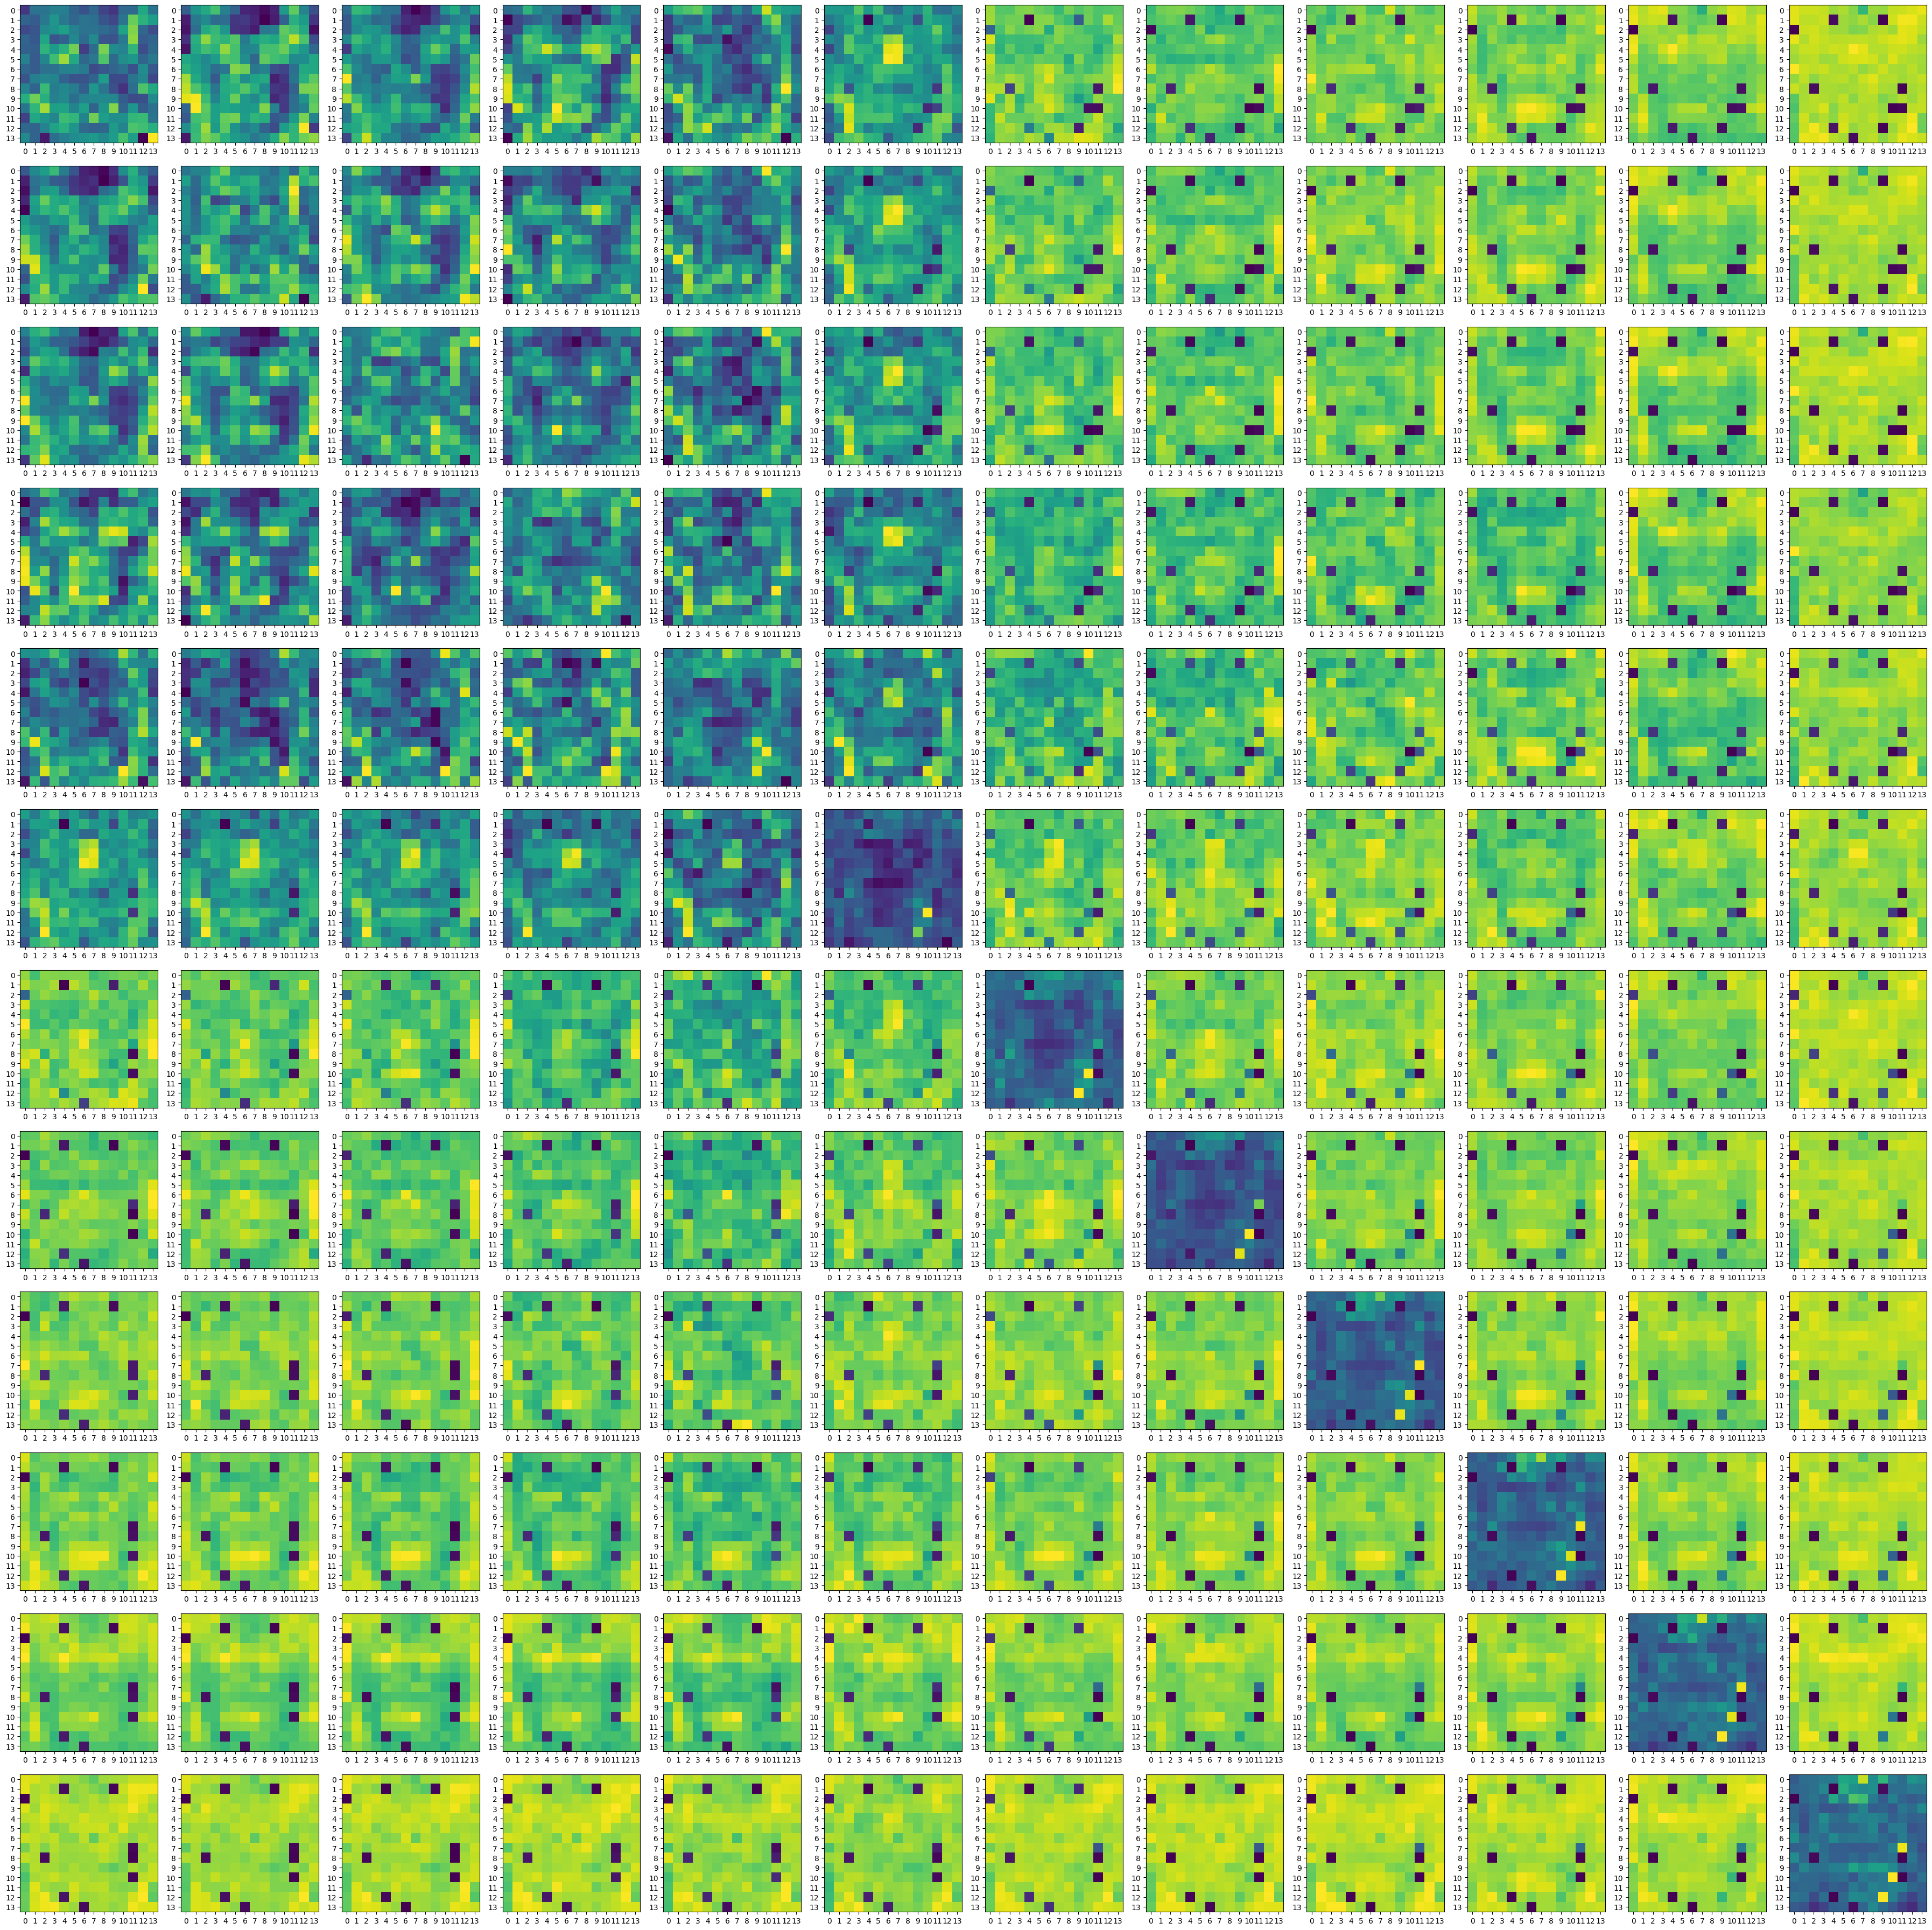

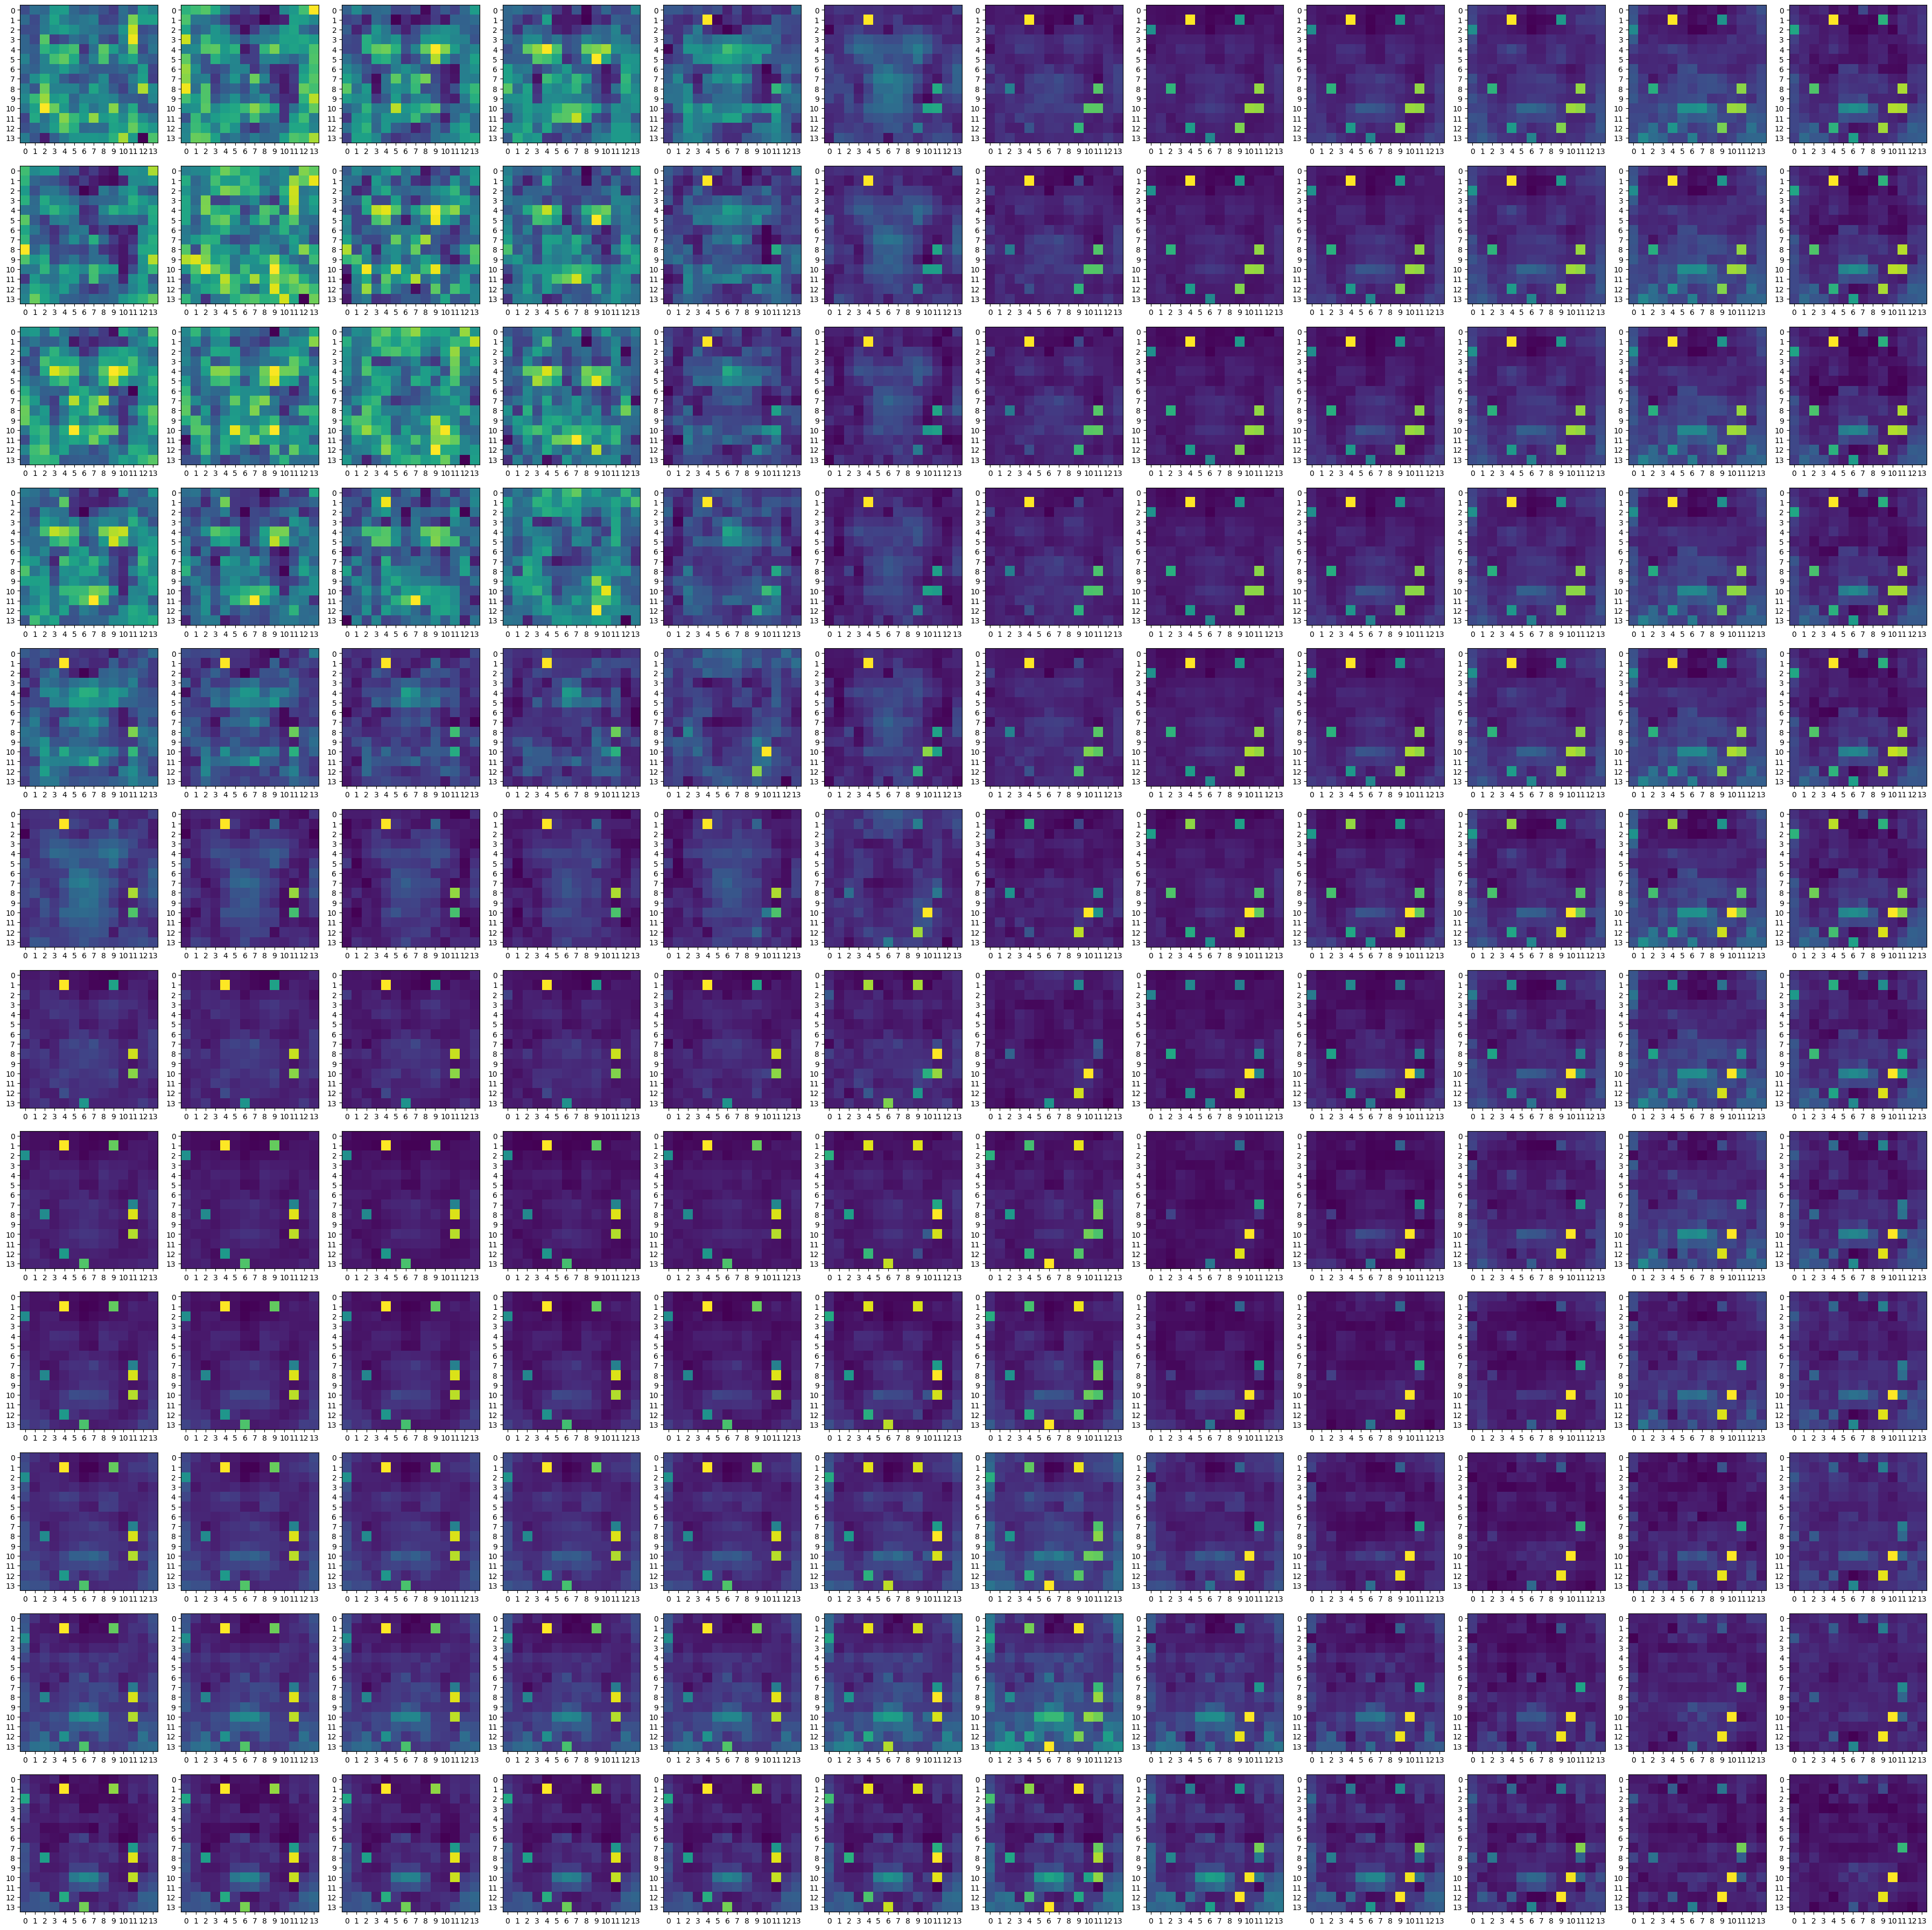

In [10]:
import numpy as np
import matplotlib.pyplot as plt
for _, s in enumerate(["k", "v", "out"]):
    for ls in methods:
        plt.figure(figsize=(36, 36))
        for j, l in enumerate(ls):
            for i, v in enumerate(l[s]):
                plt.subplot(12, 12, j * 12 + i + 1)
                im = plt.imshow(v)

                # Show all ticks and label them with the respective list entries
                plt.gca().set_xticks(np.arange(14))
                plt.gca().set_yticks(np.arange(14))

                # Rotate the tick labels and set their alignment.
                # plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
                #          rotation_mode="anchor")

        plt.tight_layout()
        plt.show()

In [ ]:
# nmethods = []

In [ ]:
# l = {
#     "k": [],
#     "v": []
# }
# for layer in range(6):
#     for subject in ["k", "v"]:
#         l[subject].append(
#             torch.nn.functional.mse_loss(
#                 nfeatures["raw"][layer][subject],
#                 nfeatures["c23"][layer][subject],
#                 reduction="none"
#             ).mean(dim=-1).view(14, 14).numpy()
#         )
# nmethods.append(l)

In [ ]:
# l = {
#     "k": [],
#     "v": []
# }
# for layer in range(6):
#     for subject in ["k", "v"]:
#         l[subject].append(
#             torch.nn.functional.kl_div(
#                 torch.nn.functional.log_softmax(nfeatures["raw"][layer][subject], dim=-1),
#                 torch.nn.functional.log_softmax(nfeatures["c23"][layer][subject], dim=-1),
#                 log_target=True,
#                 reduction="none"
#             ).mean(dim=-1).view(14, 14).numpy()
#         )
# nmethods.append(l)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# loc = [5, 6, 7, 8, 9, 10]
# for l in nmethods:
#     plt.figure(figsize=(36, 6))
#     for j, s in enumerate(["k", "v"]):
#         for i, v in enumerate(l[s]):
#             plt.subplot(2, 12, j * 12 + loc[i] + 1)
#             im = plt.imshow(v)

#             # Show all ticks and label them with the respective list entries
#             plt.gca().set_xticks(np.arange(14))
#             plt.gca().set_yticks(np.arange(14))

#             # Rotate the tick labels and set their alignment.
#             # plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
#             #          rotation_mode="anchor")

#     plt.tight_layout()
#     plt.show()

In [ ]:
# len(nmethods[0]["k"])

In [ ]:
# import random
# num_samples = 1000
# image_features = []
# for _ in range(num_samples):
#     idx = random.randint(0, len(x))
#     data = x[idx]

#     features = {}

#     with torch.no_grad():
#         for k, v in data[0].items():
#             # get key and value from each CLIP ViT layer
#             kvs = encoder(v.to("cuda"))
#             # discard original CLS token and restore temporal dimension
#             kvs = [{k: v[:, 1:] for k, v in kv.items()} for kv in kvs]
#             kvs = [{k: v[0].view((-1, 768)).to("cpu") for k, v in kv.items()} for kv in kvs]
#             features[k] = kvs
#         image_features.append(features)

#     torch.cuda.empty_cache()

# methods = []

# ls = []
# for features in image_features:
#     l = {
#         "k": [],
#         "v": []
#     }
#     for layer in range(12):
#         for subject in ["k", "v"]:
#             l[subject].append(
#                 torch.nn.functional.mse_loss(
#                     features["raw"][layer][subject],
#                     features["c23"][layer][subject],
#                     reduction="none"
#                 ).mean(dim=-1).view(14, 14).numpy()
#             )
#     ls.append(l)

# l = ls[0]
# for _l in range(1, num_samples):
#     for subject in ["k", "v"]:
#         for layer in range(12):
#             l[subject][layer] += ls[_l][subject][layer]

# for subject in ["k", "v"]:
#     for layer in range(0, 12):
#         l[subject][layer] /= num_samples

# methods.append(l)


# # l = {
# #     "k": [],
# #     "v": []
# # }
# # for layer in range(12):
# #     for subject in ["k", "v"]:
# #         l[subject].append(
# #             torch.nn.functional.kl_div(
# #                 torch.nn.functional.log_softmax(features["raw"][layer][subject], dim=-1),
# #                 torch.nn.functional.log_softmax(features["c23"][layer][subject], dim=-1),
# #                 log_target=True,
# #                 reduction="none"
# #             ).mean(dim=-1).view(14, 14).numpy()
# #         )
# # methods.append(l)

# import numpy as np
# import matplotlib.pyplot as plt
# for l in methods:
#     plt.figure(figsize=(36, 6))
#     for j, s in enumerate(["k", "v"]):
#         for i, v in enumerate(l[s]):
#             plt.subplot(2, 12, j * 12 + i + 1)
#             im = plt.imshow(v)

#             # Show all ticks and label them with the respective list entries
#             plt.gca().set_xticks(np.arange(14))
#             plt.gca().set_yticks(np.arange(14))

#             # Rotate the tick labels and set their alignment.
#             # plt.setp(plt.gca().get_xticklabels(), rotation=45, ha="right",
#             #          rotation_mode="anchor")

#     plt.tight_layout()
#     plt.show()